# Image Captioning with PyTorch

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

from flickr import Flickr30k

Data:

- [COCO dataset](http://cocodataset.org/#home)

- [Flickr8k](https://forms.illinois.edu/sec/1713398)

The data is provided by the Illinois University. It is free for education and research. To download it follow the [link](https://forms.illinois.edu/sec/1713398) and insert your email and former university (or school/company). 

To work with the data a PyTorch [Dataset](https://pytorch.org/docs/master/_modules/torchvision/datasets/flickr.html) class is already implemented. The source code is copied in the `flickr.py` file.

To use the pretrained model, we need the model weights and the vocabulary (we are working with texts, right?). They can be downloaded [here](https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0) and [here](https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0) respectively.

Special thanks to the [blog post](https://medium.com/analytics-vidhya/introduction-to-image-caption-generation-using-the-avengers-infinity-war-characters-6f14df09dbe5) authors for sharing the pre-trained model.

In [3]:
# MODEL DIRS
ENCODER_PATH = './encoder-5-3000.pkl'
DECODER_PATH = './decoder-5-3000.pkl'
VOCAB_PATH = './vocab.pkl'
# CONSTANTS
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1

In [4]:
def get_image(dataloader):
    image = np.rollaxis(next(iter(dataloader))[0][0].detach().numpy(), 0, 3)
    return image

def cast_tensor_to_image(image_tensor):
    image = np.rollaxis(image_tensor[0].detach().numpy(), 0, 3)
    return image

In [5]:
with open(VOCAB_PATH, 'rb') as f:
    vocab = pickle.load(f)

In [6]:
def caption_transform(caption_seqs, vocab=vocab):
    tokens = caption_seqs[0]
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    target = torch.Tensor(caption)
    return target

In [7]:
torch_caption_transform = transforms.Lambda(caption_transform)

In [ ]:
def collate_fn(data):
    """
    <author : Yunjey Choi, https://github.com/yunjey >
    Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

path_to_annotations = 'data/flickr8k' # path to flickr8k folder

path_to_flickr8k_images = 'data/flickr8k/Flickr8k.token.txt' # path to Flickr8k.token.txt file

train_dataset = Flickr30k(root=path_to_flickr8k_images,
                          ann_file=path_to_annotations,
                          transform=test_transform,
                          target_transform=torch_caption_transform
                         )

test_dataset = Flickr30k(path_to_flickr8k_images, 
                         ann_file=path_to_annotations,
                         transform=test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=32,
                                               shuffle=True,
                                               collate_fn=collate_fn
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=1,
                                              shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


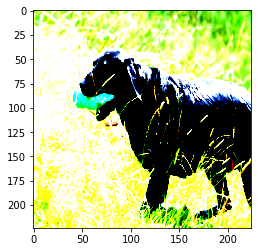

In [13]:
plt.imshow(cast_tensor_to_image(train_dataloader.dataset[22]))

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Build models
encoder = EncoderCNN(EMBED_SIZE).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, len(vocab), NUM_LAYERS)
encoder = encoder.to(device)
decoder = decoder.to(device)
# Load the trained model parameters
encoder.load_state_dict(torch.load(ENCODER_PATH))
decoder.load_state_dict(torch.load(DECODER_PATH))

In [16]:
def get_caption(image_tensor, encoder=encoder, decoder=decoder):
    image_tensor = image_tensor.to(device)
    
    # Generate a caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)[8:-5].title() 
    # Print out the image and the generated caption
    return sentence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A Small Bird Is Standing On A Branch . 
[('A bird flying in the air',), ('a bird flies low to the ground .',), ('A bird with its wings spread',), ('A hawk flies down towards the grass .',), ('A hawk is flying , trailing lines from its legs .',)]


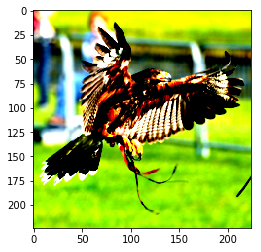

In [17]:
image, caption = next(iter(test_dataloader))
print(get_caption(image))
print(caption)

plt.imshow(cast_tensor_to_image(image))

Caution! If you want to test your network on the __test__ set, you shoud split data first. For now both train and test dataloaders work with the same images. 

It's an optional part, and it may take some time to get appropriate results. The following code is provided as a baseline.

In [18]:
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence


In [ ]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=3e-5)

# Train the models
total_step = len(train_dataloader)
for epoch in range(10):
    for i, (images, captions, lengths) in enumerate(train_dataloader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 10, i, total_step, loss.item(), np.exp(loss.item()))) 

Epoch [0/10], Step [0/253], Loss: 7.8942, Perplexity: 2681.7942
Epoch [0/10], Step [1/253], Loss: 7.7838, Perplexity: 2401.4449
Epoch [0/10], Step [2/253], Loss: 7.7815, Perplexity: 2395.8793
Epoch [0/10], Step [3/253], Loss: 7.7904, Perplexity: 2417.2878
Epoch [0/10], Step [4/253], Loss: 7.6790, Perplexity: 2162.4375
Epoch [0/10], Step [5/253], Loss: 7.5916, Perplexity: 1981.5615
Epoch [0/10], Step [6/253], Loss: 7.6345, Perplexity: 2068.2657
Epoch [0/10], Step [7/253], Loss: 7.4832, Perplexity: 1777.8567
Epoch [0/10], Step [8/253], Loss: 7.5664, Perplexity: 1932.1564
Epoch [0/10], Step [9/253], Loss: 7.5458, Perplexity: 1892.8074
Epoch [0/10], Step [10/253], Loss: 7.5634, Perplexity: 1926.3185
Epoch [0/10], Step [11/253], Loss: 7.3701, Perplexity: 1587.8585
Epoch [0/10], Step [12/253], Loss: 7.4689, Perplexity: 1752.7591
Epoch [0/10], Step [13/253], Loss: 7.3644, Perplexity: 1578.8430
Epoch [0/10], Step [14/253], Loss: 7.3674, Perplexity: 1583.5380
Epoch [0/10], Step [15/253], Loss: 